# Wild Fire Model Evaluation

This notebooks will evaluate severals model on the wildfire dataset in order to make a predecction on fire intensity and CO2 emissions. A down selection will be made to 2-3 models for further hyper-paramater tuning. 

#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [101]:
#optional code to ensure everyone is on the right version
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


# Import all the models we will likely use for classificaiton

In [102]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.utils import resample

#from imblearn import under_sampling, over_sampling
#from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC


# Helper function to save estimator
Saves to current working directory

In [103]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        
    #print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [104]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

# Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally

In [105]:
#Read the data from disk for faster access

df_fires = pd.read_csv('../data/FireIntensity_Model_June12_Clean.csv')

In [106]:
# Random Sample of DF to reduce size:

df_fires = df_fires.sample(frac=0.06, replace=True, random_state=1)
print(df_fires.shape)

(79735, 26)


# Assess shape and data in the file. 
Check data to ensure it's correct.


In [107]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [108]:
# review datagram
print (df_fires.shape)
df_fires.head(3)

(79735, 26)


,Unnamed: 0,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat,bright_t31,frp
128037,128037,47.14930,-96.03110,121,4,2004,2004_6351,7,0,1,1,313.22433,2,37.87000,0.57000,0.00000,3.56500,17.85000,24.89000,352.90000,Severe,Moderate,Low,Moderate,295.50000,201.10000
491755,491755,29.01650,-96.50580,275,10,2007,2007_1494,3,2,1,1,253.31436,3,89.27000,0.54000,0.00000,9.99700,3.27000,13.04000,318.20000,High,Moderate,Low,Low,302.50000,6.80000
470924,470924,48.32260,-113.14880,230,8,2007,2007_696,1,1,3,1260,6594.53440,2,65.37000,0.28000,0.00000,9.21629,5.90000,11.17000,334.80000,Severe,Moderate,Low,Low,297.90000,27.00000


In [109]:
df_fires = df_fires.drop(columns={'latitude', 'longitude','cluster_reference', 'doy', 'month', 'year', 'brightness', 'bright_t31','frp'})

In [110]:
df_fires.head(2)

,Unnamed: 0,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat
128037,128037,7,0,1,1,313.22433,2,37.87000,0.57000,0.00000,3.56500,17.85000,24.89000,Severe,Moderate,Low,Moderate
491755,491755,3,2,1,1,253.31436,3,89.27000,0.54000,0.00000,9.99700,3.27000,13.04000,High,Moderate,Low,Low


In [111]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [113]:
#show the shape of the data

print (df_fires.shape)
print (df_fires.describe())
print ("")
print ("")
print(df_fires['fire_intensity_twocat'].value_counts())

(79735, 17)
         Unnamed: 0  fire_region      season   covertype    fuelcode  \
count   79735.00000  79735.00000 79735.00000 79735.00000 79735.00000   
mean   665459.51176      2.74442     1.32910     2.34726   830.17217   
std    383704.69249      2.11983     1.04549     0.88031   707.68699   
min        40.00000      0.00000     0.00000     1.00000     1.00000   
25%    333523.00000      1.00000     0.00000     1.00000     1.00000   
50%    666796.00000      2.00000     1.00000     3.00000  1160.00000   
75%    997565.00000      4.00000     2.00000     3.00000  1280.00000   
max   1328921.00000      7.00000     3.00000     3.00000  2950.00000   

       prefire_fuel  fuel_moisture_class  temperature    humidity  \
count   79735.00000          79735.00000  79735.00000 79735.00000   
mean     3850.43632              2.26499     69.96958     0.41157   
std      3004.19931              0.70752     14.95296     0.16915   
min        19.72714              1.00000      2.51000     0.030

# Setting Up Features:

In [115]:
features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

cat_features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class']

num_features = ['prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

target = ['fire_intensity_twocat']

y = df_fires[target]
y = np.ravel(y)
X = df_fires[features]

#encode_columns = ('fire_region', 'season', 'covertype', 'fuel_moisture_class')
#onehot_list = df_fires[encode_columns]

--- 
Review features:

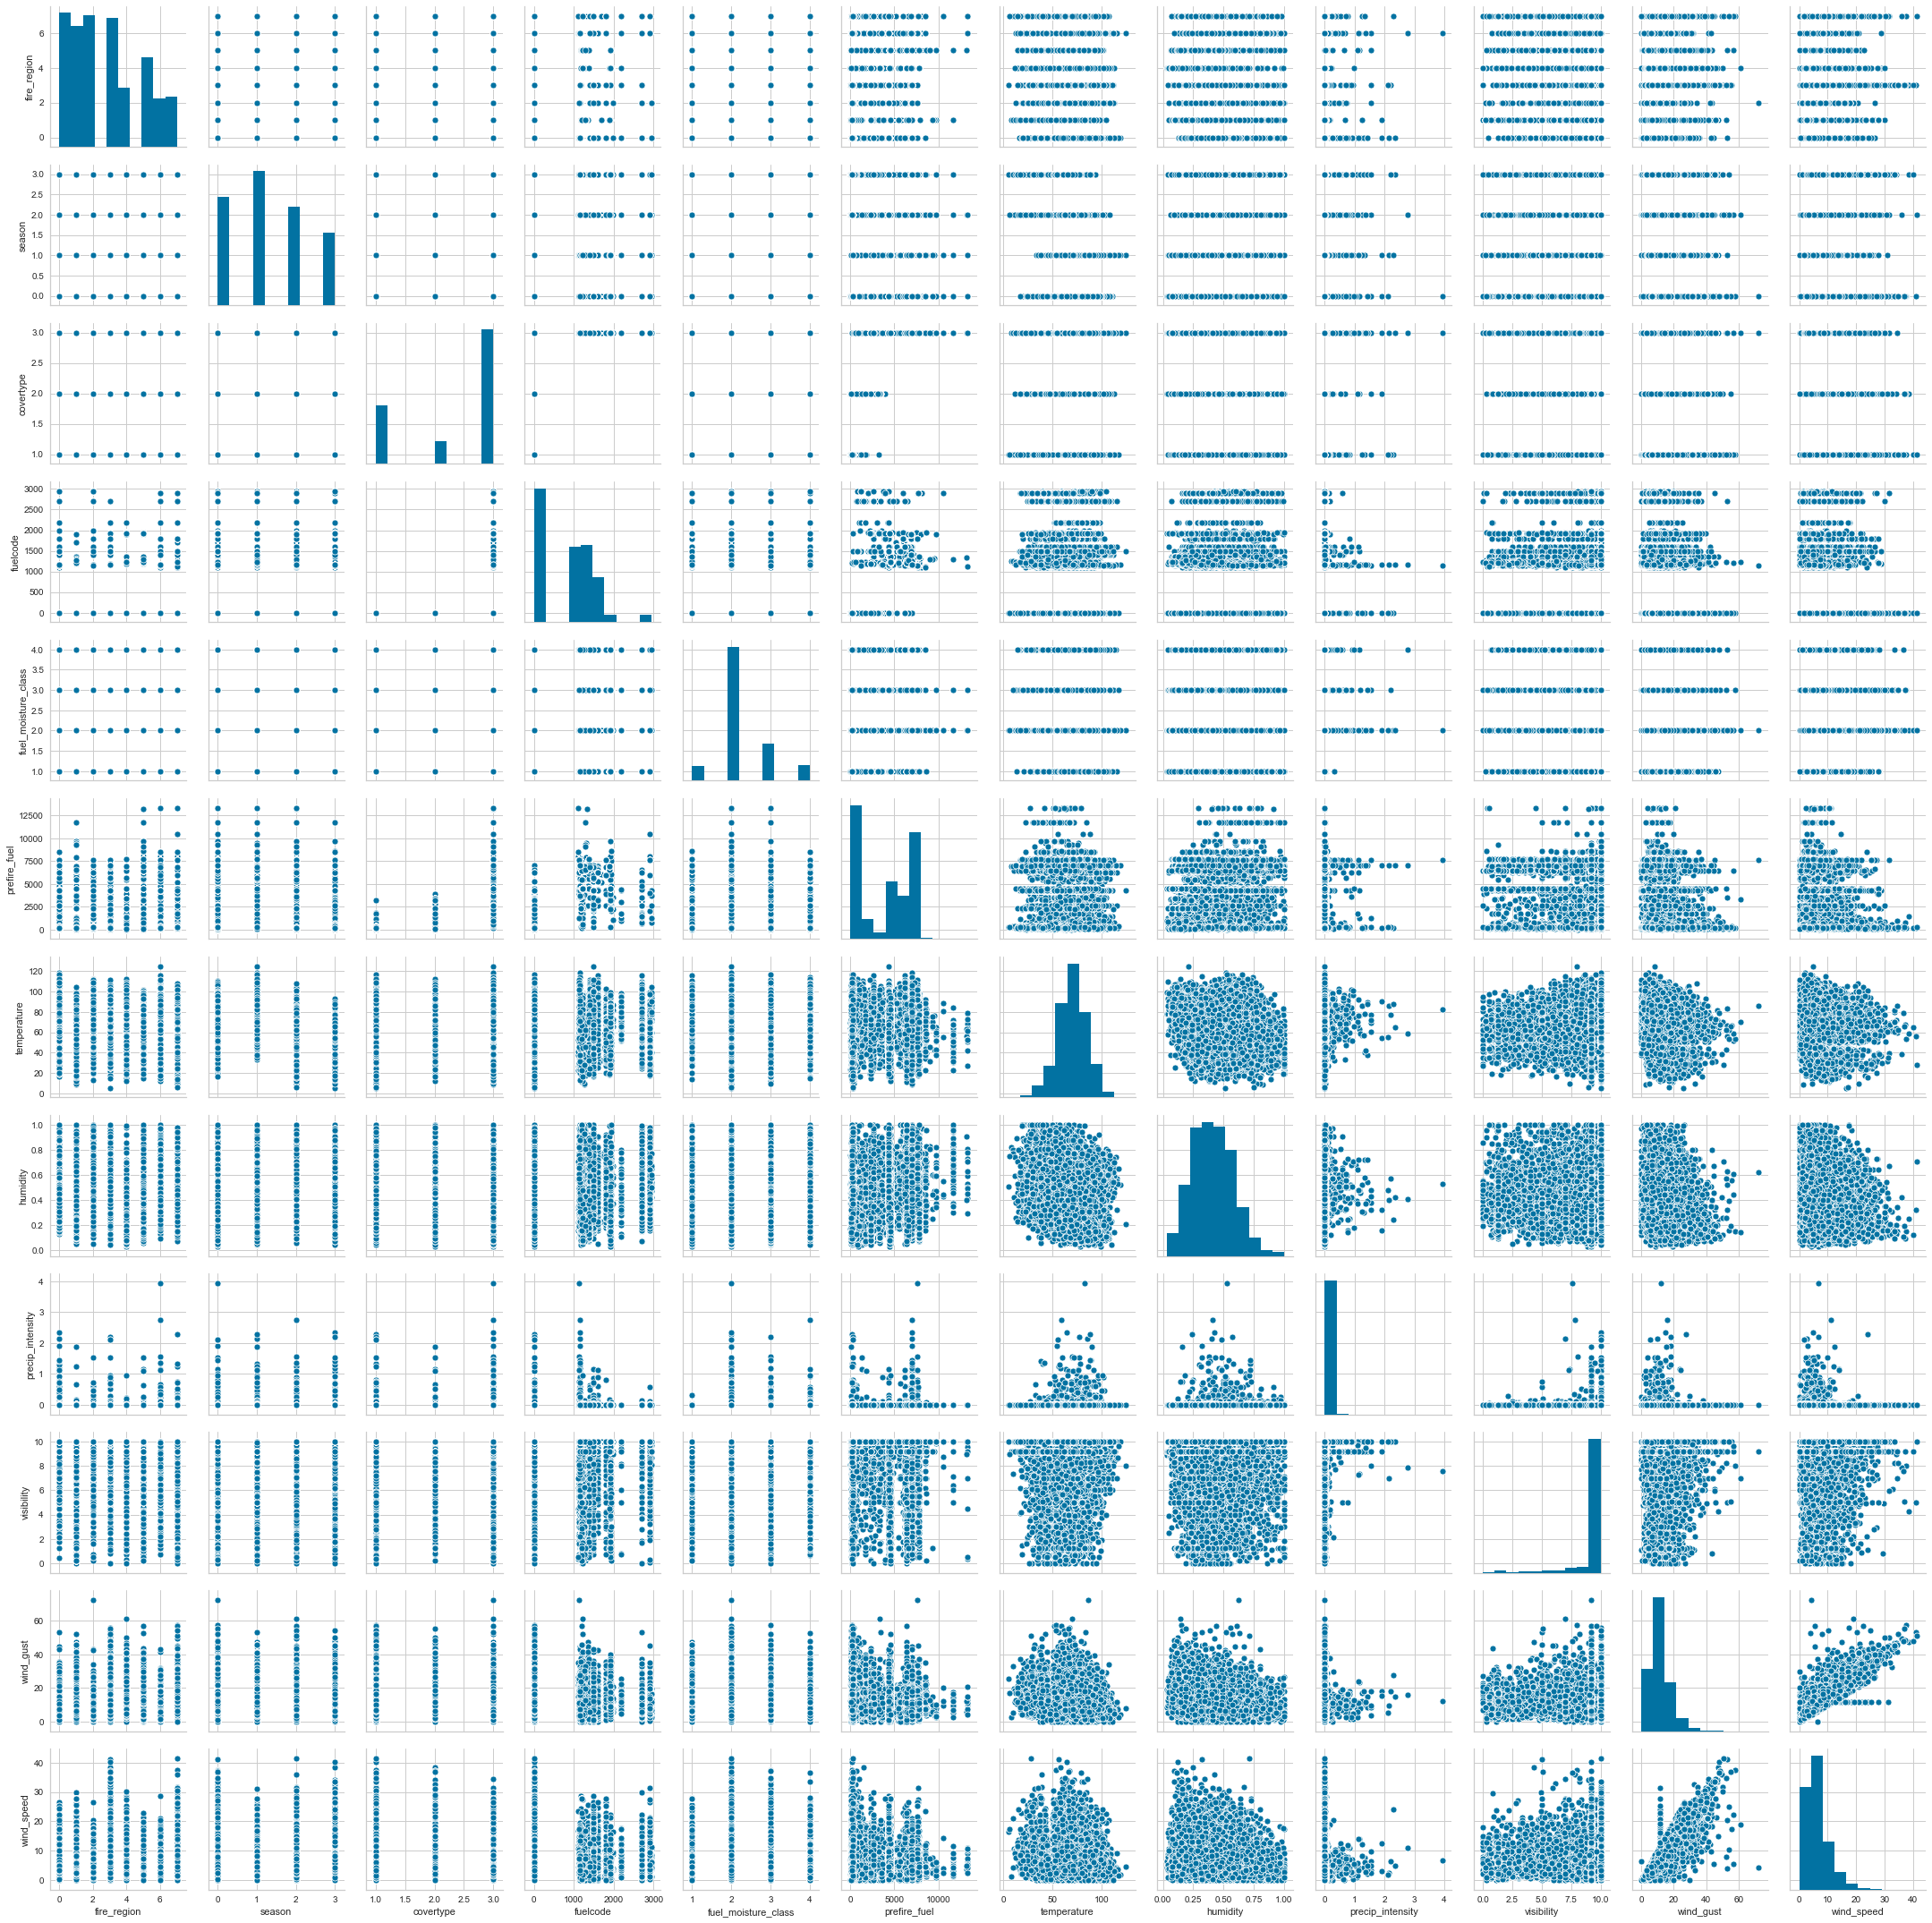

In [51]:
sns.pairplot(X)

## Pipeline to Transform:

In [116]:
# Processing y.
y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling

In [117]:
# Processing X Features. 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

#numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True))])
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(25, 75)))])
#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    #('imputer', SimpleImputer(strategy='median')),


In [118]:
# Setting the transformation for the pipeline below. 
preprocessor = ColumnTransformer (transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


#column_trans = make_column_transformer((OneHotEncoder(), ['fire_region', 'season',
 #                               'fuelcode', 'fuel_moisture_class']),
  #                               remainder='passthrough')
    
column_trans.fit_transform(X)
y = LabelEncoder().fit_transform(y)


# Define the models to test
<b>Commented out slower performing models and limited the interations/estimators for speed</b>

In [119]:
'''
    models = [
        SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
        LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
        RandomForestClassifier(n_estimators=100),
        ]    
'''
models = [RandomForestClassifier(n_estimators=100) ]
#models = [AdaBoostClassifier()]

# Function to Fit and predict the scores of the model. 
Helps in the initial down selection

In [121]:
def score_model(X, y, estimator, **kwargs):
    
    """
    Test various estimators.
    #y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories = 'auto')), 
         ('estimator', estimator)
    ])
    """ 
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
   
    return save_estimator(estimator)


# Iterate through the different models

In [122]:
for model in models:
    score_model(X, y, model)

RandomForestClassifier: 0.7036441405357919


# Function to visualize the model out using yellow brick classification report.
<b> Error is thrown here using the LabelEncoder and one_hot_encoder <b/>

In [126]:
def visualize_model(X, y, estimator):
    
    """
    Test various estimators.
    
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])
    """ 
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
   
   
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model,
        classes=['Moderate','Severe'],  # Classes for 2 Category Fire Intensity
        #classes=['Low', 'Moderate_to_High', 'Severe'],  # Classes for 3 Category Fire Intensity
        #classes=['Low', 'Medium', 'High', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )
    
    #X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33) #random_state=42)

    """"
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
    negative = train_data[train_data.diagnosis=='Moderate']
    positive = train_data[train_data.diagnosis=='Severe']
    
    # upsample minority
    pos_upsampled = resample(positive,
    replace=True, # sample with replacement
    n_samples=len(negative), # match number in majority class
    random_state=27) # reproducible results# combine majority and upsampled minority
    
    upsampled = pd.concat([negative, pos_upsampled])# check new class counts
    upsampled.diagnosis.value_counts()
    """
                                           
    visualizer.fit(X_train, y_train)  
        
    visualizer.score(X_test, y_test)
    
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()


# Iterate through the models to visualize

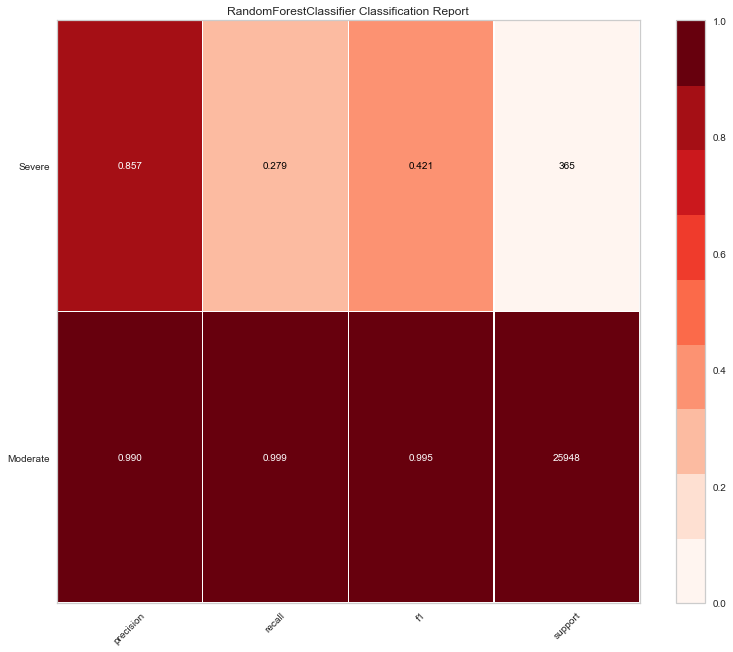

In [127]:
for model in models:
    visualize_model(X, y, model)
    

---
#### ROCAUC

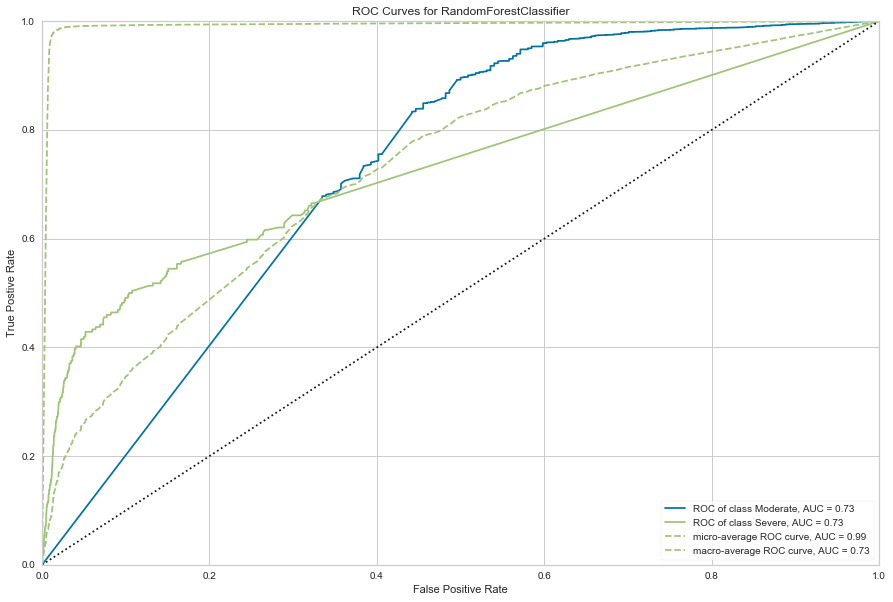

In [130]:

#classes = ['win', 'loss', 'draw']

# Encode the non-numeric columns
#X = OrdinalEncoder().fit_transform(X)
#y = LabelEncoder().fit_transform(y)

classes=['Moderate','Severe']  # Classes for 2 Category Fire Intensity
#classes=['Low', 'Moderate_to_High', 'Severe']  # Classes for 3 Category Fire Intensity
#classes=['Low', 'Medium', 'High', 'Severe']

# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

visualizer = ROCAUC(RandomForestClassifier(n_estimators=100), classes=classes, size=(1080, 720))
#visualizer = ROCAUC(RandomForestClassifier(n_estimators=100), size=(1080, 720))
#visualizer = ROCAUC(BaggingClassifier(), size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

---
#### Class Balance

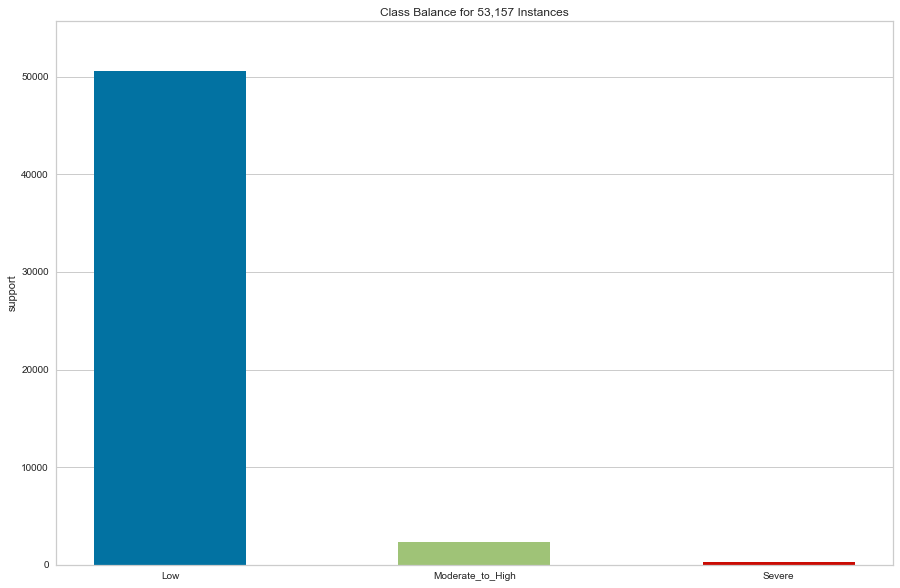

In [71]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
#visualizer = ClassBalance(size=(1080, 720))
visualizer = ClassBalance(labels=['Low', 'Moderate_to_High', 'Severe'], size=(1080, 720))

visualizer.fit(y)
visualizer.show()

---
#### Cross Validation

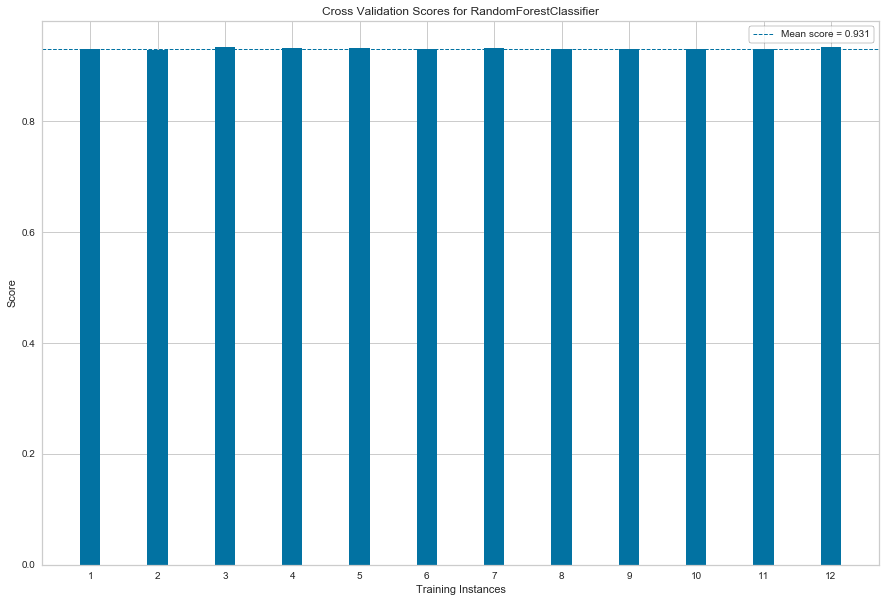

In [82]:
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores

# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
#model = RandomForestClassifier(n_estimators=100)
model = RandomForestClassifier(n_estimators=100)
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X, y)
visualizer.show()